# Trénovanie modelu iba na základe DST indexu 24 h dozadu, predikcia súčasnej hodnoty
Súbor: 24_dozadu.ipynb

Program: Hospodárska informatika

Vypracovala: Bc. Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, PhD., RNDr. Šimon Mackovjak, PhD.

### Inštalácia knižníc

In [ ]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

### Kontrola kapacity servera

In [1]:
!nvidia-smi

Mon Feb 27 10:23:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:8B:00.0 Off |                  N/A |
| 44%   36C    P0    26W / 105W |      0MiB /  8192MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import knižníc

In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [3]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
            'DST']
test = test[features]
train = train[features]
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST'

y_col='DST'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train[y_col].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid[y_col].values.copy()
y_test = test[y_col].values.copy()
X_test = test[y_col].values.copy()

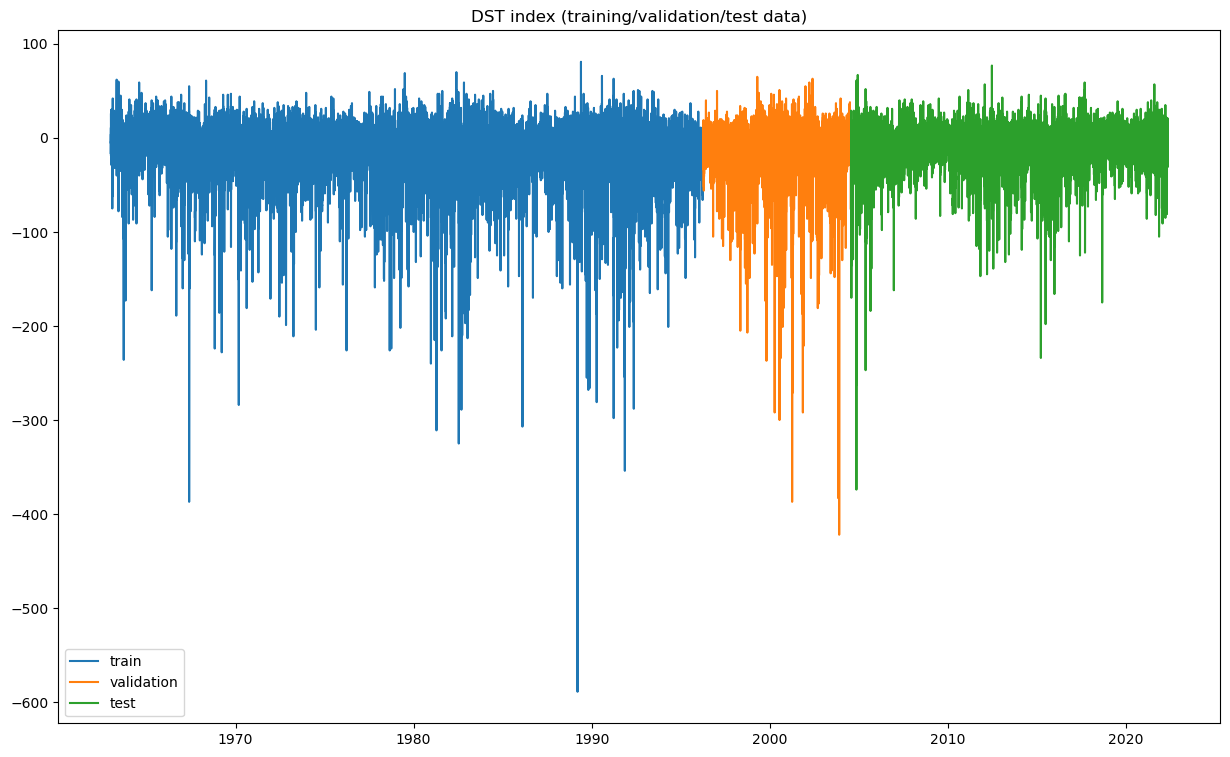

In [4]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST'],label='train')
plt.plot(valid['time1'],valid['DST'],label='validation')
plt.plot(test['time1'],test['DST'],label='test')
plt.legend();

In [5]:
# set batch, n_input, n_features

n_input = 24  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [6]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1139
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  24


In [7]:
inputs = Input(shape=(n_input,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2023-02-27 10:23:29.956664: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7414 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:8b:00.0, compute capability: 6.1


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 24, 256)          133120    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 24, 128)           197120    
                                                                 
 time_distributed (TimeDistr  (None, 24, 1)            129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25    

In [8]:
# callbacks
saved_model = "24_dozadu.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [9]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20


2023-02-27 10:23:36.984884: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


1139/1139 [==============================] - ETA: 0s - loss: 119.1846 - mae: 5.6277
Epoch 1: val_mae improved from inf to 3.80842, saving model to 24_dozadu.hdf5
1139/1139 [==============================] - 221s 188ms/step - loss: 119.1846 - mae: 5.6277 - val_loss: 59.1258 - val_mae: 3.8084
Epoch 2/20
1139/1139 [==============================] - ETA: 0s - loss: 42.2598 - mae: 3.8322
Epoch 2: val_mae improved from 3.80842 to 3.49954, saving model to 24_dozadu.hdf5
1139/1139 [==============================] - 212s 186ms/step - loss: 42.2598 - mae: 3.8322 - val_loss: 39.6064 - val_mae: 3.4995
Epoch 3/20
1139/1139 [==============================] - ETA: 0s - loss: 44.4238 - mae: 3.8649
Epoch 3: val_mae improved from 3.49954 to 3.43492, saving model to 24_dozadu.hdf5
1139/1139 [==============================] - 211s 185ms/step - loss: 44.4238 - mae: 3.8649 - val_loss: 39.5755 - val_mae: 3.4349
Epoch 4/20
1139/1139 [==============================] - ETA: 0s - loss: 33.4757 - mae: 3.4929
Epoc

In [10]:
# load best model
model = keras.models.load_model('24_dozadu.hdf5')

In [11]:
# prediction
y_pred = model.predict(test_generator)

607/607 [==============================] - 18s 28ms/step


In [12]:
y_pred

array([[-45.04696 ],
       [-79.34751 ],
       [-76.07289 ],
       ...,
       [-28.150097],
       [-21.120316],
       [-22.568226]], dtype=float32)

In [13]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[123381   1235]
 [  5124  25495]]


In [14]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    124616
           1       0.95      0.83      0.89     30619

    accuracy                           0.96    155235
   macro avg       0.96      0.91      0.93    155235
weighted avg       0.96      0.96      0.96    155235



In [15]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [16]:
df

,time,y_true,y_predict
24,2004-07-22 22:00:00,-67.0,-45.046959
25,2004-07-22 23:00:00,-85.0,-79.347511
26,2004-07-23 00:00:00,-87.0,-76.072891
27,2004-07-23 01:00:00,-90.0,-78.426544
28,2004-07-23 02:00:00,-99.0,-80.397789
...,...,...,...
155254,2022-04-28 20:00:00,-29.0,-24.026264
155255,2022-04-28 21:00:00,-31.0,-26.708916
155256,2022-04-28 22:00:00,-25.0,-28.150097
155257,2022-04-28 23:00:00,-24.0,-21.120316


In [17]:
df.describe()

,y_true,y_predict
count,155235.000000,155235.000000
mean,-9.819834,-8.926864
std,16.340604,15.262658
min,-374.000000,-321.186523
25%,-16.000000,-15.588132
50%,-7.000000,-6.177037
75%,0.000000,0.959206
max,77.000000,51.022652


<AxesSubplot: >

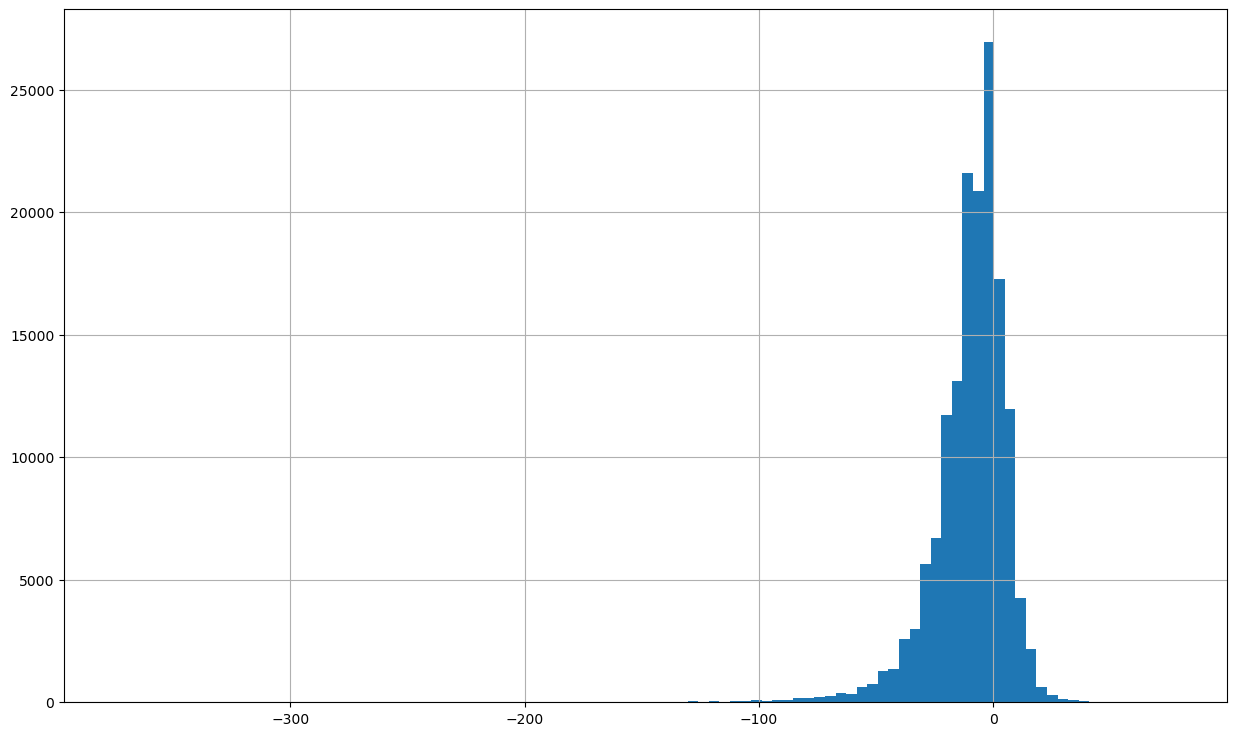

In [18]:
df["y_true"].hist(bins=100)

<AxesSubplot: >

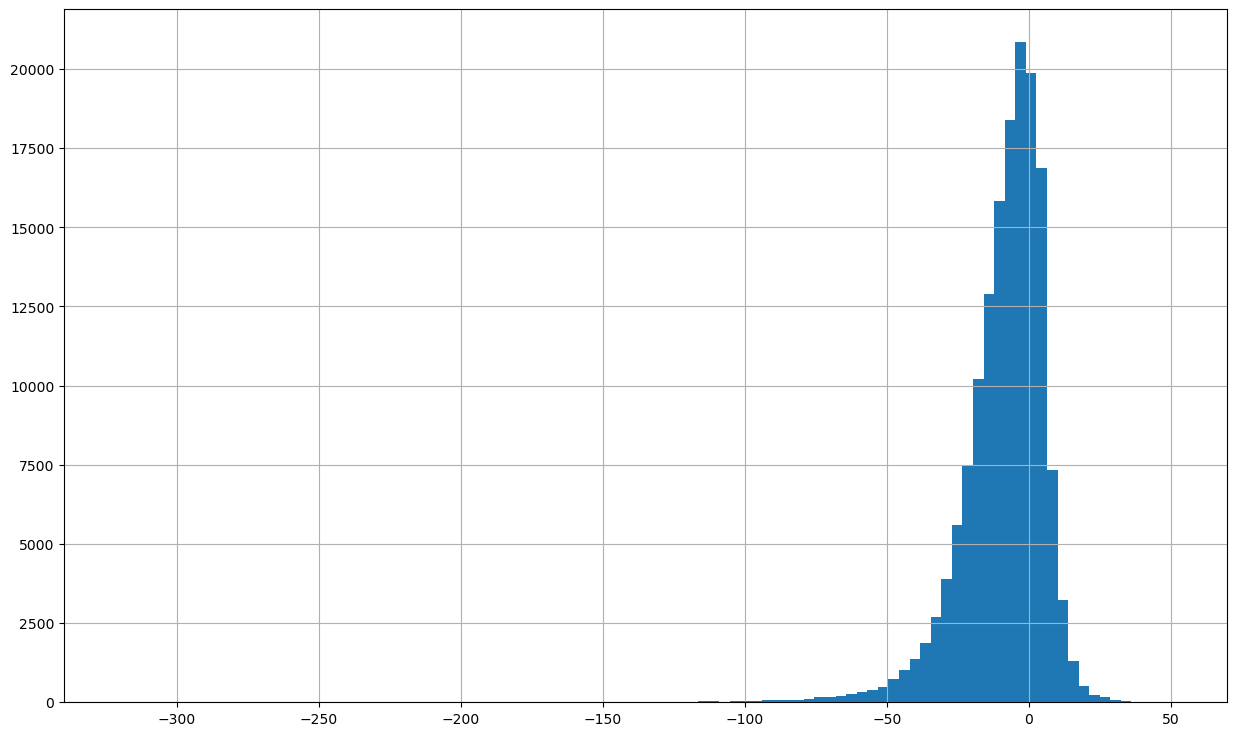

In [19]:
df["y_predict"].hist(bins=100)

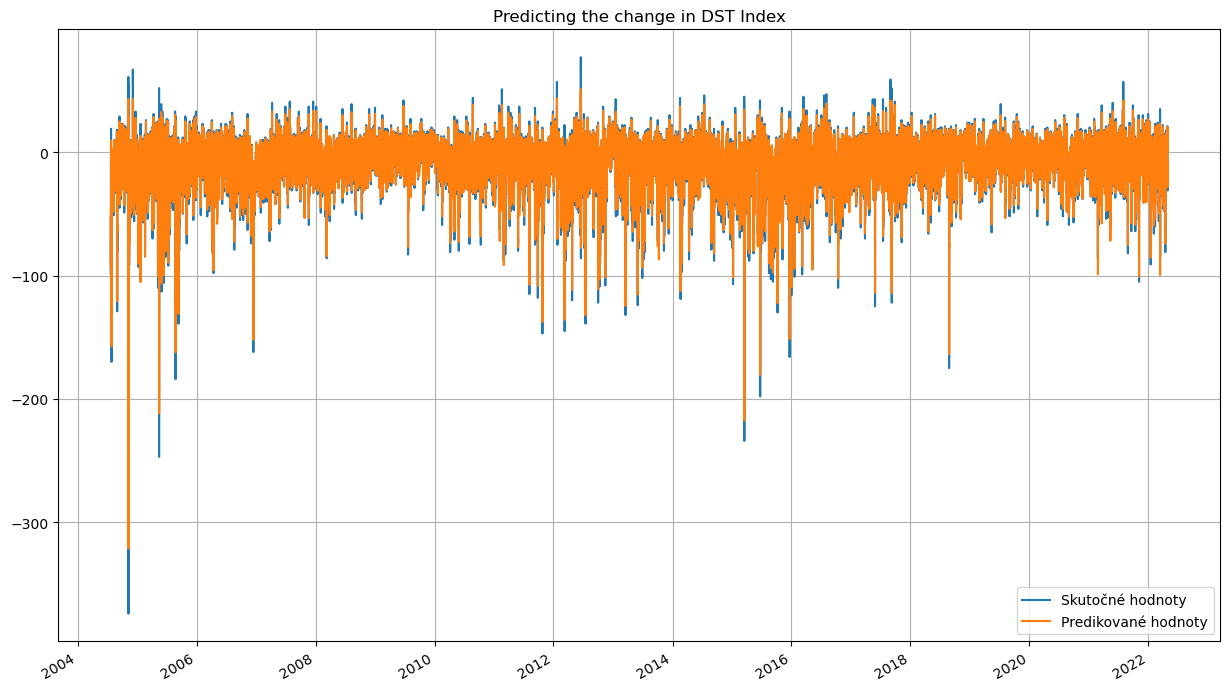

In [20]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [21]:
df.to_csv('predikcie_24h_dozadu.csv')

In [22]:
TN = cm[0,0] 
print(TN)
FP = cm[0,1]
print(FP)
FN = cm[1,0] 
print(FN)
TP = cm[1,1] 
print(TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("TPR={}".format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP)
print("TNR={}".format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("PPV={}".format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print("NPV={}".format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("FPR={}".format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print("FNR={}".format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print("FDR={}".format(FDR))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("ACC={}".format(ACC))
MCC = matthews_corrcoef(y_test2, y_pred2)
print("MCC={}".format(MCC))

123381
1235
5124
25495
TPR=0.8326529279205722
TNR=0.9900895551133081
PPV=0.9537972315750094
NPV=0.9601260651336524
FPR=0.009910444886691917
FNR=0.1673470720794278
FDR=0.046202768424990645
ACC=0.9590362998035237
MCC=0.8671352388391295
